In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyteomics import proforma, mass
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

In [2]:
def proforma_to_sus_modifications(proforma_sequence):
    """Modifications dictionary for spectrum_utils.spectrum."""
    sus_mods = dict()
    parsed_sequence, modifiers = proforma.parse(proforma_sequence)

    for i, (_, mods) in enumerate(parsed_sequence):
        if mods:
            sus_mods[i] = sum(mod.mass for mod in mods)
    if modifiers["n_term"]:
        sus_mods["N-term"] = sum(mod.mass for mod in modifiers["n_term"])
    if modifiers["c_term"]:
        sus_mods["C-term"] = sum(mod.mass for mod in modifiers["c_term"])
    return sus_mods

def _sus_annotation_to_index(ann, num_ions):
    """Convert spectrum_utils annotation to correct array index."""
    col_indices = {
        ("a", 1): 0,
        ("b", 1): 1,
        ("y", 1): 2,
        ("a", 2): 3,
        ("b", 2): 4,
        ("y", 2): 5
    }
    return col_indices[ann.ion_type, ann.charge], ann.ion_index - 1

def _get_intensities_spectrum_utils(sus_spectrum):
    """Ëxtract fragment ion intensities from spectrum using spectrum_utils."""
    num_ions = len(sus_spectrum.peptide) - 1
    x, y = np.vectorize(_sus_annotation_to_index)(
        sus_spectrum.annotation[sus_spectrum.annotation != None], num_ions
    )
    intensities = np.full((6, num_ions), 0.0)  # Set full array to nan
    intensities[x, y] = sus_spectrum.intensity[sus_spectrum.annotation != None]
    return intensities.flatten()

In [3]:
def process_peptide(proforma_seq, correlations):
    parsed_sequence, modifiers = proforma.parse(proforma_seq)
    sequence = "".join([p[0] for p in parsed_sequence])
    
    spectrum_syn_df = pd.read_csv(f"input/spectra/MS2 spectra - synthetic - {sequence}.csv", dtype=np.float32).dropna()
    spectrum_obs_df = pd.read_csv(f"input/spectra/MS2 spectra - Listeria - {sequence}.csv", dtype=np.float32).dropna()
    
    spectrum_syn = (
        sus.MsmsSpectrum(
            identifier=proforma_seq + " (synthetic)",
            precursor_mz=mass.calculate_mass(sequence, charge=modifiers["charge_state"].charge),
            precursor_charge=modifiers["charge_state"].charge,
            mz=spectrum_syn_df["MS2 m/z"],
            intensity=spectrum_syn_df["Relative Intensity in %"],
            peptide=sequence,
            modifications=proforma_to_sus_modifications(proforma_seq)
        )
        .annotate_peptide_fragments(50, "ppm", ion_types='aby')
        .remove_precursor_peak(50, "ppm", isotope=2)
        .filter_intensity(min_intensity=0.05)
    )
    
    spectrum_obs = (sus.MsmsSpectrum(
            identifier=proforma_seq + " (Listeria)",
            precursor_mz=mass.calculate_mass(sequence, charge=modifiers["charge_state"].charge),
            precursor_charge=modifiers["charge_state"].charge,
            mz=spectrum_obs_df["MS2 m/z"],
            intensity=spectrum_obs_df["Relative Intensity in %"],
            peptide=sequence,
            modifications=proforma_to_sus_modifications(proforma_seq)
        )
        .annotate_peptide_fragments(50, "ppm", ion_types='aby')
        .remove_precursor_peak(50, "ppm", isotope=2)
        .filter_intensity(min_intensity=0.05)
    )

    # Extract annotated ions and calculate correlations
    annotated_ions_syn = _get_intensities_spectrum_utils(spectrum_syn)
    annotated_ions_obs = _get_intensities_spectrum_utils(spectrum_obs)
    corr = np.corrcoef(annotated_ions_obs, annotated_ions_syn)[0,1]
    
    correlations.append([proforma_seq, corr])  #, corr_log])
    
    plt.title(f"{proforma_seq} ({corr:.4f})")
    sup.mirror(spectrum_obs, spectrum_syn)
    plt.savefig(f"output/mirror-plots/{sequence}.svg", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

In [4]:
peptide_df = pd.read_csv("input/peptides.csv")
peptide_df

,proforma
0,VAYGRQVYL/2


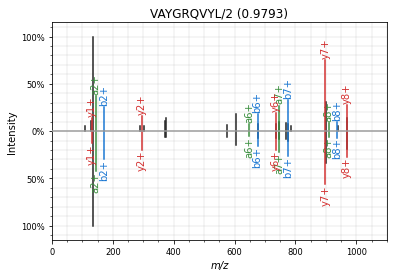

In [5]:
try:
    os.mkdir("output/mirror-plots")
except FileExistsError:
    pass

correlations = []

for proforma_seq in peptide_df['proforma'].values:
    process_peptide(proforma_seq, correlations)

In [6]:
corr_df = pd.DataFrame(correlations, columns=["peptide", "correlation"])
corr_df

,peptide,correlation
0,VAYGRQVYL/2,0.979349


In [7]:
corr_df.to_csv("output/correlations.csv", index=False)